<a href="https://colab.research.google.com/github/UMassIonTrappers/quantum-computing-labs/blob/main/Lab_05_Noise_and_composite_pulses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650 QC

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

#Note : Matplot lib 3.4 required. Animations will not work without uninstalling and reinstalling then restarting the kernel 'runtime'

OR

Replace:

ax = Axes3D(fig,azim=-40,elev=30)

With

ax = fig.add_subplot(111, projection="3d", azim=-40, elev=30)

ax.set_position([0, 0, 0.95, 1])

In [ ]:
'''
If plots of the Bloch sphere are not working you may have to revert the matplotlib back to 3.4.0

Qutip doesn't work with matplotlib 3.5
Qiskit doesn't work with matplotlib 3.4.3

Requires uninstall and then install of matplotlib.__version__ == '3.4.0'

ALSO, you must restart the kernel 'runtime' using the 'exit()' command

'''

try:
  import matplotlib
  print(matplotlib.__version__)
except ImportError:
  print('Install Matplotlib')

if matplotlib.__version__ > '3.4.0':
  print ("Need to downgrade matplotlib to work with Qutip and Qisket")
  !pip uninstall -y matplotlib
  !pip install matplotlib==3.4.0
  import matplotlib ;  print(matplotlib.__version__)
  #Restart runtime to reload Matplot lib
  exit()


In [ ]:
import matplotlib
print(matplotlib.__version__)

if matplotlib.__version__ == '3.4.0':
  print("Congratulations! Animations should work!")
else:
  print("Try again!!")


#QuTiP

All labs will be run in the colaboratory Jupyter notebook like this one.

To get started we first need to install QuTiP using 'pip' within Colab.

(Any library not native to Colab can be installed this way.)

In [ ]:
try:
  import qutip
except ImportError:
  print('Install Qutip')
  !pip install --quiet qutip

#Qiskit

IBM's Quantum Information Software Kit

In [ ]:
try:
  import qiskit
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

In [ ]:
#Install Qiskit Aer so you can import QasmSimulator
!pip install qiskit-aer

In [ ]:
try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install qiskit-aer
  from qiskit import QuantumCircuit, transpile, assemble
  from qiskit.visualization import plot_bloch_multivector, plot_histogram
  from qiskit_aer import QasmSimulator

In [ ]:
'''
Kaleidoscope plots Bloch spheres for Qisket
'''
try:
  import kaleidoscope
except ImportError:
  print('Install kaleidoscope')
  !pip install --quiet kaleidoscope
import kaleidoscope; print(kaleidoscope.__version__)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import qutip as qt
from qutip import *
from qutip.qip import *
from qutip import qeye, tensor, destroy, fock_dm

import numpy as np
from numpy import pi, sqrt, sin, cos


In [ ]:
# '''
# CIRQ has a nice conversion of universal gates in QASM which we will use to translate between QUTIP and QISKET
# '''
# try:
#     import cirq
# except ImportError:
#     print("install cirq")
#     !pip install --quiet cirq


# !pip install --quiet ply==3.4

In [ ]:
'''
New library from Qutip
https://arxiv.org/pdf/2105.09902v2.pdf
'''

!pip install --quiet qutip-qip

### Initialize

In [ ]:
%matplotlib inline
from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#QuTiP imports
import qutip as qt
from qutip import *
from qutip.qip import *
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate
from qutip_qip.qasm import circuit_to_qasm_str

#Qisket imports
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram
# from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector
from kaleidoscope import bloch_sphere


#Lab 5

References:
* Progress in compensating pulse sequences for quantum computation - https://arxiv.org/abs/1203.6392

#Noise and decoherence

 Noise and the decoherence it introduces to the qubits is the main issue limiting quantum computation.

Environmental noise like:

*   Fluctations in external fields
*   Fluctations in applied fields

all contribute to dephasing and decoherence.

Further, qubit excited states can spontaneously decay and lose all of their information. Some can decay to 3rd states outside of the two state basis effectively 'leaking' out of the two state basis.

Let us examine fluctatations in the applied fields and then flucatations of external fields.

#Setup a $\pi$ pulse

In [ ]:
'''
Circuit representation of pi pulse (without errors)
'''
qc = QubitCircuit(1)

qc.add_gate("RY", 0, arg_value=pi)

qasmstr = circuit_to_qasm_str(qc) #Convert to QASM
qkqc = QuantumCircuit.from_qasm_str(qasmstr)#Import to Qisket
qkqc.draw('mpl')# Draw the circuit using QISKET

###Set physical parameters of pulse coupling rate (period)

In [ ]:
#Setup Rabi Coupling rate at 100kHz
Omega = 2*pi*100*10**3 # Rabi Coupling rate [Hz]
display(Math(r'\Omega= {} [kHz]'.format(round(Omega/2/pi/1e3,2))))

#Calculate the period of Rabi Oscillations
period = 2*pi/Omega # period of rotating in seconds (not seconds/radian)
print('Period=',round(period*1e6,3),'[us]')

In [ ]:
'''
Hamiltonian of the RY pulse
'''
HX = Omega/2*sigmay()

'''
Setup pulse timing

Add 20% Error to the amplitude of the field (or equivalently to the timing of the pulse)

'''
percent_error = 0.20
pulse_error= 1-percent_error
times = np.linspace(0, pulse_error*(pi)/Omega, 10) # pi pulse with error


In [ ]:
# Initialize the state
psi0 = spin_state( 1/2, +1/2)
psi0=psi0.unit()

'''
Apply the first pulse (integrate the Schrodinger Equation)
'''
result = sesolve(HX, psi0, times, [])

#Project the state onto the Z axis (find the expectation values)
sx =  expect(sigmax(), result.states)
sy =  expect(sigmay(), result.states)
sz =  expect(sigmaz(), result.states)

In [ ]:
#Animate on the Bloch Sphere
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)
sphere.point_color = ['r']

#Animation function
def animate(i):
    sphere.clear()
    sphere.vector_color = ['r','y','y','y','k']
    sphere.add_points([sx[:i+1],sy[:i+1],sz[:i+1]], meth='l') #Point for each step of the rotation
    sphere.add_vectors([sx[i],sy[i],sz[i]]) #Full vector
    sphere.add_vectors([sx[i],0,0]) #Just the X basis component
    sphere.add_vectors([0,sy[i],0]) #Just the Y basis component
    sphere.add_vectors([0,0,sz[i]]) #Just the Z basis component
    # sphere.add_vectors([1,0,0]) #Rotation axis (X)
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['r']
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(sx)),init_func=init, blit=False, repeat=True)

HTML(ani.to_jshtml())


In [ ]:
#Plot results
fs=20
fig, ax = plt.subplots(1,1)
plt.style.use('default')
plt.grid()

ax.plot(times*Omega/pi,sz,'-k')

plt.title('Spin flip - 20% short pulse error', fontsize=fs*.7)
ax.set_ylabel(r'$S_z$', fontsize=fs);
ax.set_xlabel(r'Pulse length [$\pi$ period]', fontsize=fs*.7);
plt.ylim(-1.05, 1.05)

We can see the pulse was only 80% of it's full period so it was 'short' and 'undershot'.

The error is just the difference compared to our desired state.

In [ ]:
print('Rotation error=',round(100*(1+sz[-1])/2,2),'%')

#Composite pulse sequence

It is possible to correct/account for this 'undershoot' error with a composite pulse sequence.

Composite pulse sequence 1

1. Split the RX(π) rotation into TWO RX(π/2) rotations
2. Insert an RY(π) rotation in between

By changing the rotation axis inbetween and effectively applying two pulses (one in X and one in Y) over/under shoot error is dramatically reduced!


Let's create the circuit and pulse sequence to try it out:

In [ ]:
'''
Circuit representation
'''
qc = QubitCircuit(1)

rotation = pi

qc.add_gate("RX", 0, arg_value=rotation/2)

qc.add_gate("RY", 0, arg_value=rotation)

qc.add_gate("RX", 0, arg_value=rotation/2)

qasmstr = circuit_to_qasm_str(qc) #Convert to QASM
qkqc = QuantumCircuit.from_qasm_str(qasmstr)#Import to Qisket
qkqc.draw('mpl')# Draw the circuit using QISKET

References:
* https://arxiv.org/abs/quant-ph/0208092v1
* https://www.ucl.ac.uk/quantum-spins/sites/quantum-spins/files/paper90.pdf


In [ ]:
# Initialize the state
psi0 = spin_state( 1/2, +1/2)
psi0=psi0.unit()

#Hamiltonian of the RX pulses
HX = Omega/2*sigmax()
HY = Omega/2*sigmay()

'''
Setup pulses
'''
percent_error = 0.20
pulse_error= 1-percent_error
times = np.linspace(0, pulse_error*(pi/2)/Omega, 10) # pi/2 pulse with error
times2 = np.linspace(0, pulse_error*(pi/2)/Omega*2, 2*10) # pi pulse with error

#Apply the first RX/2 pulse
result = sesolve(HX, psi0, times, [])

#Project the state onto the Z axis (find the expectation values)
sx =  expect(sigmax(), result.states)
sy =  expect(sigmay(), result.states)
sz =  expect(sigmaz(), result.states)

'''
Apply the 2nd pulse

Feed forward the end state of the first pulse to the Schrodiner Equation
And concatenate the expectation values all together
'''
#Apply the RY pulse
result = sesolve(HY, result.states[-1], times2, [])

#Project the state onto the Z axis (find the expectation values)
sx2 =  expect(sigmax(), result.states)
sy2 =  expect(sigmay(), result.states)
sz2 =  expect(sigmaz(), result.states)
sx=np.concatenate((sx,sx2))
sy=np.concatenate((sy,sy2))
sz=np.concatenate((sz,sz2))

'''
Apply the 3rd pulse

Feed forward the end state of the second pulse to the Schrodiner Equation
Continue concatenating the expectation values all together
'''
#Apply the 2nd RX/2 pulse
result = sesolve(HX, result.states[-1], times, [])

#Project the state onto the Z axis (find the expectation values)
sx2 =  expect(sigmax(), result.states)
sy2 =  expect(sigmay(), result.states)
sz2 =  expect(sigmaz(), result.states)
sx=np.concatenate((sx,sx2))
sy=np.concatenate((sy,sy2))
sz=np.concatenate((sz,sz2))

In [ ]:

#Animate the result on the Bloch Sphere

fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)
sphere.point_color = ['r']

#Animation function
def animate(i):
    sphere.clear()
    sphere.vector_color = ['r','y','y','y','k']
    sphere.add_points([sx[:i+1],sy[:i+1],sz[:i+1]], meth='l') #Point for each step of the rotation
    sphere.add_vectors([sx[i],sy[i],sz[i]]) #Full vector
    sphere.add_vectors([sx[i],0,0]) #Just the X basis component
    sphere.add_vectors([0,sy[i],0]) #Just the Y basis component
    sphere.add_vectors([0,0,sz[i]]) #Just the Z basis component
    # sphere.add_vectors([1,0,0]) #Rotation axis (X)
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['r']
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(sx)),init_func=init, blit=False, repeat=True)
HTML(ani.to_jshtml())


In [ ]:
#Plot results
fig, ax = plt.subplots(1,1)
plt.style.use('default')
plt.grid()
ax.plot(sz,'-k')
plt.title('Spin flip - Composite pulse sequence')
ax.set_ylabel(r'$S_z$', fontsize=20);
plt.ylim(-1.05, 1.05)

In [ ]:
print('Rotation error=',round(100*(1+sz[-1])/2,2),'%')

We have taken a 20% pulse error and achieved a ~1% deviation to our desired state by using a composite pulse sequence!

This type of pulse control is very common in Nuclear Magnetic Resonance imaging.

#Compensation for Off-Resonance with a Pulse SEquence (Frequency noise)

If we are detuned from resonance we will have an extra rotation about Z during our X,Y rotations.

To compensate for this we can use a 'CORPSE' pulse sequence, which stands for (Compensation for Off-Resonance with a Pulse SEquence).

CORPSE pulse sequence for an RX(π) pulse is:
1.   RX($\frac{7π}{3}$)
2.   Negative RX($\frac{5π}{3}$) ( negative = 180deg out-of-phase)
3.   RX($\frac{π}{3}$)

>Note that the 'cost' for this robustness is that the length of the pulse is now over **4X the time**.

>Reference:
https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.93.157005

In [ ]:
'''
Circuit representation
'''
qc = QubitCircuit(1)

qc.add_gate("RX", 0, arg_value=7*pi/3)

qc.add_gate("RX", 0, arg_value=-5*pi/3)

qc.add_gate("RX", 0, arg_value=pi/3)

qasmstr = circuit_to_qasm_str(qc) #Convert to QASM
qkqc = QuantumCircuit.from_qasm_str(qasmstr)#Import to Qisket
qkqc.draw('mpl')# Draw the circuit using QISKET

First without the CORPSE:

In [ ]:
from IPython.display import display, Math

Omega = 2*pi*100*10**3 # Rabi Coupling rate [Hz]
display(Math(r'\Omega= {} [kHz]'.format(round(Omega/2/pi/1e3,2))))
period = 2*pi/Omega # period of rotating in seconds (not seconds/radian)
print('Period=',round(period*1e6,3),'[us]')

#Large detuning
detuning = 2*pi*30e3
display(Math(r'\delta= {} [kHz]'.format(round(detuning/2/pi/1e3,2))))


In [ ]:
# Initialize the state
psi0 = spin_state( 1/2, +1/2)
psi0=psi0.unit()

#Hamiltonian of the RX pulses
HX = Omega/2*sigmax()+detuning/2*sigmaz()

# time of the pulses
times = np.linspace(0, (pi/2)/Omega, 20) # pi/2 pulse

#Apply the first pulse
result = sesolve(HX, psi0, times, [])

#Project the state onto the Z axis (find the expectation values)
sx =  expect(sigmax(), result.states)
sy =  expect(sigmay(), result.states)
sz =  expect(sigmaz(), result.states)

#Apply the 2nd pulse
result = sesolve(HX, result.states[-1], times, [])

#Project the state onto the Z axis (find the expectation values)
sx2 =  expect(sigmax(), result.states)
sy2 =  expect(sigmay(), result.states)
sz2 =  expect(sigmaz(), result.states)
sx=np.concatenate((sx,sx2))
sy=np.concatenate((sy,sy2))
sz=np.concatenate((sz,sz2))

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)
sphere.point_color = ['r']

#Animation function
def animate(i):
    sphere.clear()
    sphere.vector_color = ['r','y','y','y','k']
    sphere.add_points([sx[:i+1],sy[:i+1],sz[:i+1]], meth='l') #Point for each step of the rotation
    sphere.add_vectors([sx[i],sy[i],sz[i]]) #Full vector
    sphere.add_vectors([sx[i],0,0]) #Just the X basis component
    sphere.add_vectors([0,sy[i],0]) #Just the Y basis component
    sphere.add_vectors([0,0,sz[i]]) #Just the Z basis component
    # sphere.add_vectors([1,0,0]) #Rotation axis (X)
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['r']
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(sx)),init_func=init, blit=False, repeat=True)
HTML(ani.to_jshtml())


In [ ]:
#Plot results
fig, ax = plt.subplots(1,1)
plt.style.use('default')
plt.grid()
ax.plot(sz,'-k')
plt.title('Spin flip off resonance')
ax.set_ylabel(r'$S_z$', fontsize=20);
plt.ylim(-1,1)

In [ ]:
print('Rotation error=',round(100*(1+sz[-1])/2,3),'%')

Now with CORPSE

In [ ]:
# Initialize the state
psi0 = spin_state( 1/2, +1/2)
psi0=psi0.unit()

#Hamiltonians of the pulses
HX = Omega/2*sigmax()+detuning/2*sigmaz()
HXn = -Omega/2*sigmax()+detuning/2*sigmaz()

# time of the pulses
times = np.linspace(0, (7*pi/3)/Omega, 20) # pi/2 pulse
times2 = np.linspace(0, (5*pi/3)/Omega, 15) # pi/2 pulse
times3 = np.linspace(0, (pi/3)/Omega, 5) # pi/2 pulse

#Apply the first RX pulse
result = sesolve(HX, psi0, times, [])

#Project the state onto the Z axis (find the expectation values)
sx =  expect(sigmax(), result.states)
sy =  expect(sigmay(), result.states)
sz =  expect(sigmaz(), result.states)

#Apply the negative phase RX pulse
result = sesolve(HXn, result.states[-1], times2, [])

#Project the state onto the Z axis (find the expectation values)
sx2 =  expect(sigmax(), result.states)
sy2 =  expect(sigmay(), result.states)
sz2 =  expect(sigmaz(), result.states)
sx=np.concatenate((sx,sx2))
sy=np.concatenate((sy,sy2))
sz=np.concatenate((sz,sz2))

#Apply the 3rd RX pulse
result = sesolve(HX, result.states[-1], times3, [])

#Project the state onto the Z axis (find the expectation values)
sx2 =  expect(sigmax(), result.states)
sy2 =  expect(sigmay(), result.states)
sz2 =  expect(sigmaz(), result.states)
sx=np.concatenate((sx,sx2))
sy=np.concatenate((sy,sy2))
sz=np.concatenate((sz,sz2))

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)
sphere.point_color = ['r']

#Animation function
def animate(i):
    sphere.clear()
    sphere.vector_color = ['r','y','y','y','k']
    sphere.add_points([sx[:i+1],sy[:i+1],sz[:i+1]], meth='l') #Point for each step of the rotation
    sphere.add_vectors([sx[i],sy[i],sz[i]]) #Full vector
    sphere.add_vectors([sx[i],0,0]) #Just the X basis component
    sphere.add_vectors([0,sy[i],0]) #Just the Y basis component
    sphere.add_vectors([0,0,sz[i]]) #Just the Z basis component
    # sphere.add_vectors([1,0,0]) #Rotation axis (X)
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['r']
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(sx)),init_func=init, blit=False, repeat=True)
HTML(ani.to_jshtml())


In [ ]:
#Plot results
fig, ax = plt.subplots(1,1)
plt.style.use('default')
plt.grid()
ax.plot(sz,'-k')
plt.title('Spin flip off resonance with CORPSE')
ax.set_ylabel(r'$S_z$', fontsize=20);
plt.ylim(-1.05, 1.05)

In [ ]:
print('Rotation error=',round(100*(1+sz[-1])/2,3),'%')

#Exercises:

1. Plot the fidelity of a pulse vs **amplitude/field noise** with and without Composite Pulses. (Plot up to $\pm$50% error in the pulse length).
* X axis (% error of pulse length)
* Y axis (% error from desired final state)

2. Plot the fidelity of a pulse vs **detuning noise** with and without CORPSE.
(Plot up to $\pm$50% error in the pulse detuning)

1. What is the extra time of each pulse sequence? Composite Pulses? CORPSE?

1. How many sequential pulses with 1% error can you run before you're at 50/50 odds of getting the final desired state?

1. If you can perform a $π$ pulse (X,Y) in 10us and have amplitude errors of $\pm$ 1% (over/undershoot). At what $T_2$ time does it become worth it to perform extra composite pulses? That is, at what $T_2$ time ($T_2$ = 1/dephasing rate) would error from amplitude noise be equal to your error from dephasing?


In [ ]:
'''
Exercise 1
'''



In [ ]:
'''
Exercise n
'''



#Hints

In [ ]:
#Setup Rabi Coupling rate at 100kHz
Omega = 2*pi*100*10**3 # Rabi Coupling rate [Hz]
display(Math(r'\Omega= {} [kHz]'.format(round(Omega/2/pi/1e3,2))))

#Calculate the period of Rabi Oscillations
period = 2*pi/Omega # period of rotating in seconds (not seconds/radian)
print('Period=',round(period*1e6,3),'[us]')


# Initialize the state
psi0 = spin_state( 1/2, +1/2)
psi0=psi0.unit()

#Hamiltonian of the RX pulses
HX = Omega/2*sigmax()
HY = Omega/2*sigmay()

#Plot results
fig, ax = plt.subplots(1,1)
plt.style.use('default')
plt.grid()


'''
Setup pulses
'''

percent_error = 0.50
pulse_errors = np.linspace( 1-percent_error,1, 10)

for pulse_error in pulse_errors:

  times = np.linspace(0, pulse_error*(pi/2)/Omega, 10) # pi/2 pulse with error
  times2 = np.linspace(0, pulse_error*(pi/2)/Omega*2, 2*10) # pi pulse with error

  #Apply the first RX/2 pulse
  result = sesolve(HX, psi0, times, [])

  #Project the state onto the Z axis (find the expectation values)
  sx =  expect(sigmax(), result.states)
  sy =  expect(sigmay(), result.states)
  sz =  expect(sigmaz(), result.states)

  '''
  Apply the 2nd pulse

  Feed forward the end state of the first pulse to the Schrodiner Equation
  And concatenate the expectation values all together
  '''
  #Apply the RY pulse
  result = sesolve(HY, result.states[-1], times2, [])

  #Project the state onto the Z axis (find the expectation values)
  sx2 =  expect(sigmax(), result.states)
  sy2 =  expect(sigmay(), result.states)
  sz2 =  expect(sigmaz(), result.states)
  sx=np.concatenate((sx,sx2))
  sy=np.concatenate((sy,sy2))
  sz=np.concatenate((sz,sz2))

  '''
  Apply the 3rd pulse

  Feed forward the end state of the second pulse to the Schrodiner Equation
  Continue concatenating the expectation values all together
  '''
  #Apply the 2nd RX/2 pulse
  result = sesolve(HX, result.states[-1], times, [])

  #Project the state onto the Z axis (find the expectation values)
  sx2 =  expect(sigmax(), result.states)
  sy2 =  expect(sigmay(), result.states)
  sz2 =  expect(sigmaz(), result.states)
  sx=np.concatenate((sx,sx2))
  sy=np.concatenate((sy,sy2))
  sz=np.concatenate((sz,sz2))


  ax.plot(sz,'-k')
  plt.title('Spin flip - Composite pulse sequence')
  ax.set_ylabel(r'$S_z$', fontsize=20);
  plt.ylim(-1.05, 1.05)

  Error = round(100*(1+sz[-1])/2,3)
  print('Rotation error=',round(100*(1+sz[-1])/2,3),'%')



Composite pulses for interferometry in a thermal cold atom cloud

https://arxiv.org/abs/1406.2916

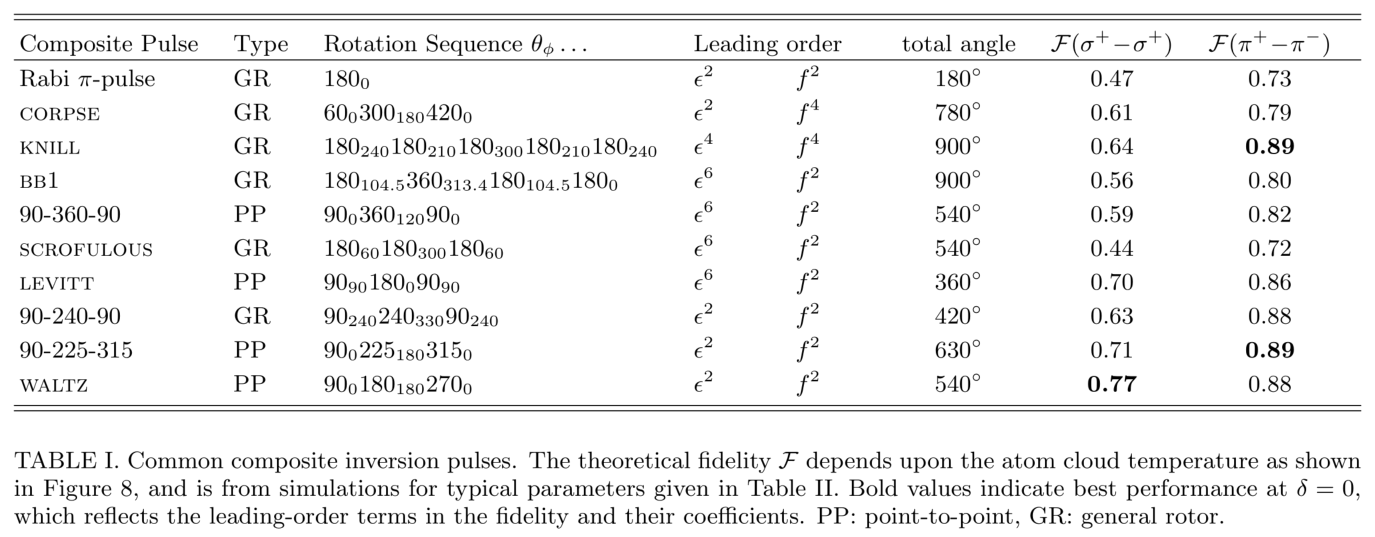

##BB1

$R(𝜃)^{ideal}_0 = R(π)_𝜙 \cdot R(2π)_{3𝜙}  \cdot R(π)_𝜙 R(𝜃)_0 $

with $𝜙 = cos^{−1}(−𝜃∕4π)$

gate rotation | gate axis| correction axis1| correction axis2
---|---|---|--
  90◦ |0| 97.2 |3*97.2= 291.5
180◦ |0| 104.5| 3*104.5= 313.4



In [ ]:
phi = np.arccos(-pi/(4*pi))
print(phi*180/pi)

print(np.sin(phi))
print(np.cos(phi))

In [ ]:
# Initialize the state
psi0 = spin_state( 1/2, +1/2)
psi0=psi0.unit()

#Desired rotation angle on the Bloch sphere
rotation = pi

#Axis of correction rotations
phi = np.arccos(-rotation/(4*pi))
print('rotation axis=', phi*180/pi)

#Setup Rabi Coupling rate at 100kHz
Omega = 2*pi*100*10**3 # Rabi Coupling rate [Hz]
display(Math(r'\Omega= {} [kHz]'.format(round(Omega/2/pi/1e3,2))))

#Calculate the period of Rabi Oscillations
period = 2*pi/Omega # period of rotating in seconds (not seconds/radian)
print('Period=',round(period*1e6,3),'[us]')

error = 0.3
print('Relative detuning error', error)
detuning = Omega*error


#Hamiltonians of the pulses
HX = Omega/2*sigmax()+detuning/2*sigmaz()
HXn = -Omega/2*sigmax()+detuning/2*sigmaz()

HCorrection1 = Omega/2*(np.sin(phi)*sigmax()+ np.cos(phi)*sigmay())+detuning/2*sigmaz()
HCorrection2 = Omega/2*(np.sin(3*phi)*sigmax()+ np.cos(3*phi)*sigmay())+detuning/2*sigmaz()
# print(HCorrection1)

# time of the pulses
tsteps = 20
times = np.linspace(0, (rotation)/Omega, tsteps) # pulse
times2 = np.linspace(0, (2*rotation)/Omega, 2*tsteps) # 2x pulse
# times3 = np.linspace(0, (rotation)/Omega, tsteps) # pi/2 pulse

'''
#Apply the first correction pulse R(π)ϕ
'''
result = sesolve(HCorrection1, psi0, times, [])

#Project the state onto the Z axis (find the expectation values)
sx =  expect(sigmax(), result.states)
sy =  expect(sigmay(), result.states)
sz =  expect(sigmaz(), result.states)

'''
#Apply the 2nd correction pulse R(2π)3ϕ
'''
result = sesolve(HCorrection2, result.states[-1], times2, [])

#Project the state onto the Z axis (find the expectation values)
sx2 =  expect(sigmax(), result.states)
sy2 =  expect(sigmay(), result.states)
sz2 =  expect(sigmaz(), result.states)
sx=np.concatenate((sx,sx2))
sy=np.concatenate((sy,sy2))
sz=np.concatenate((sz,sz2))

'''
#Apply the 3rd correction pulse (same as the first correction) R(π)ϕ
'''
result = sesolve(HCorrection1, result.states[-1], times, [])
#Project the state onto the Z axis (find the expectation values)
sx2 =  expect(sigmax(), result.states)
sy2 =  expect(sigmay(), result.states)
sz2 =  expect(sigmaz(), result.states)
sx=np.concatenate((sx,sx2))
sy=np.concatenate((sy,sy2))
sz=np.concatenate((sz,sz2))



'''
#Apply the final naive pulse (desired pulse without corrections) R(π)0
'''
result = sesolve(HX, result.states[-1], times, [])
#Project the state onto the Z axis (find the expectation values)
sx2 =  expect(sigmax(), result.states)
sy2 =  expect(sigmay(), result.states)
sz2 =  expect(sigmaz(), result.states)
sx=np.concatenate((sx,sx2))
sy=np.concatenate((sy,sy2))
sz=np.concatenate((sz,sz2))

#Plot results
fig, ax = plt.subplots(1,1)
plt.style.use('default')
plt.grid()

ax.plot(sz,'-k')
plt.title('BB1')
ax.set_ylabel(r'$S_z$', fontsize=20);
# plt.ylim(-1.05, 1.05)


In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)
sphere.point_color = ['r']

#Animation function
def animate(i):
    sphere.clear()
    sphere.vector_color = ['r','y','y','y','k']
    sphere.add_points([sx[:i+1],sy[:i+1],sz[:i+1]], meth='l') #Point for each step of the rotation
    sphere.add_vectors([sx[i],sy[i],sz[i]]) #Full vector
    sphere.add_vectors([sx[i],0,0]) #Just the X basis component
    sphere.add_vectors([0,sy[i],0]) #Just the Y basis component
    sphere.add_vectors([0,0,sz[i]]) #Just the Z basis component
    # sphere.add_vectors([1,0,0]) #Rotation axis (X)
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['r']
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(sx)),init_func=init, blit=False, repeat=True)
HTML(ani.to_jshtml())


In [ ]:
print(sz)
ax.plot(sz,'-k')